In [1]:
import numpy as np
from astropy.table import Table, vstack, Column
from astropy.io import fits, ascii
import matplotlib.pyplot as plt
import os
import warnings
import py_specrebin
import pandas as pd 
from pandas import DataFrame as df
import timeit

In [2]:
start_time = timeit.default_timer()
df = pd.read_csv('finaltable.csv')
allnames = list(df['SPEC1DNAME'])

In [3]:
types = []
files = []
path = '.\\..\\spectra\\'
for filename in os.listdir(path):
    if ((filename in allnames) | (filename[:-3] in allnames)):
        if ('[]' not in str((df[df['SPEC1DNAME']== filename])['Type'])):
            types.append(str((df[df['SPEC1DNAME']== filename])['Type']))
        else:
            types.append(str((df[df['SPEC1DNAME']== filename[:-3]])['Type']))         
        files.append(filename)
degc, denuc, icgc, m87gc, udggc, stars = [],[],[],[],[], []
for i in range(len(files)):
    if ('DE_GC' in types[i]):
        degc.append(files[i])
    elif ('DE_NUC' in types[i]):
        denuc.append(files[i])
    elif ('ICGC' in types[i]):
        icgc.append(files[i])
    elif ('M87GC' in types[i]):
        m87gc.append(files[i])
    elif ('UDG_GC' in types[i]):
        udggc.append(files[i]+'.gz')

In [4]:
vobsDEGC, vobsDENUC, vobsICGC, vobsM87, vobsUDGGC = [], [], [], [], [] 
def vobs(files):
    vobszero = np.zeros(len(files))
    for i in range(len(files)):
        try:
            vobszero[i] = (float(df[df['SPEC1DNAME'] == files[i]]['VOBS']))
        except:
            vobszero[i] = (float(df[df['SPEC1DNAME']+'.gz' == files[i]]['VOBS']))    
        return vobszero
vobsDEGC = vobs(degc)
vobsDENUC = vobs(denuc)
vobsICGC = vobs(icgc)
vobsM87 = vobs(m87gc)
vobsUDGGC = vobs(udggc)

In [5]:
def getvalues(files, velocities):
    alllambdas, allfluxes, allvariances = (np.zeros(len(files))).tolist(), (np.zeros(len(files))).tolist(), (np.zeros(len(files))).tolist()
    for i in range(len(files)):
        try:
            f = fits.open(path + files[i])        #open file
        except:
            f= fits.open(path + files[i][:-3])
        try:                                  #check for Bxspf blue or red, if not I resort to Horne
            tempB = f['Bxspf-' + 'B']
            tempR = f['Bxspf-' + 'R']
        except:
            tempB = f['Horne-' + 'B'] 
            tempR = f['Horne-' + 'R']
        originalwaveB = (tempB.data['LAMBDA'])/(1 + ((velocities[i]/300000)))     #doppler shift correction
        originalwaveR = (tempR.data['LAMBDA'])/(1 + ((velocities[i]/300000)))        #doppler shift correction
        alllambdas[i] = np.append(originalwaveB,originalwaveR)    #this is a 1D list of blue side lambdas then red
        allfluxes[i] = np.append(tempB.data['SPEC'],tempR.data['SPEC'])
        allvariances[i] = np.append(tempB.data['IVAR'], tempR.data['IVAR'])
        f.close()     #close file
    return alllambdas, allfluxes, allvariances

In [6]:
RBlambdaDEGC, RBfluxDEGC, RBvarianceDEGC = getvalues(degc, vobsDEGC)         #coaddition for UDG
RBlambdaDENUC, RBfluxDENUC, RBvarianceDENUC = getvalues(denuc, vobsDENUC)         #coaddition for UDG
RBlambdaICGC, RBfluxICGC, RBvarianceICGC = getvalues(icgc, vobsICGC)         #coaddition for UDG
RBlambdaM87GC, RBfluxM87GC, RBvarianceM87GC = getvalues(m87gc, vobsM87)         #coaddition for UDG
RBlambdaUDGGC, RBfluxUDGGC, RBvarianceUDGGC = getvalues(udggc, vobsUDGGC)         #coaddition for UDG

In [7]:
correct = np.arange(4000,8750.9,0.9)          #generate new wavelengths to work with
def rebinspec(wavelength, flux, newrange, var):
    fluxes = np.zeros((len(wavelength), len(newrange)))
    ivars = np.zeros((len(wavelength), len(newrange)))
    for i in range(len(wavelength)):  
        newflux, newvar = np.nan_to_num(py_specrebin.rebinspec(wavelength[i],flux[i], correct, ivar = var[i]))  #rebinspec DE
        fluxes[i][:] = newflux
        ivars[i][:] = newvar
    return fluxes, ivars
fluxDEGC, varsDEGC = rebinspec(RBlambdaDEGC, RBfluxDEGC, correct, RBvarianceDEGC)
fluxDENUC, varsDENUC = rebinspec(RBlambdaDENUC, RBfluxDENUC, correct, RBvarianceDENUC)
fluxICGC, varsICGC = rebinspec(RBlambdaICGC, RBfluxICGC, correct, RBvarianceICGC)
fluxM87GC, varsM87GC = rebinspec(RBlambdaM87GC, RBfluxM87GC, correct, RBvarianceM87GC)
fluxUDGGC, varsUDGGC = rebinspec(RBlambdaUDGGC, RBfluxUDGGC, correct, RBvarianceUDGGC)

In [8]:
def normalize(minlimit, maxlimit, flux, ivar):
    correct = list(np.arange(4000,8750.9,0.9))          
    rangeflux = np.asarray(flux)[:, correct.index(min(correct, key=lambda x:abs(x-minlimit))): correct.index(min(correct, key=lambda x:abs(x-maxlimit)))]
    rowmedians = np.median(rangeflux, axis=1)
    for i in range(len(rangeflux)):
        flux[i] = flux[i]/rowmedians[i]
        ivar[i] = ivar[i] * np.power(rowmedians[i],2)
    return flux, ivar 
minl = 8400
maxl = 8700
nfluxDEGC, nvarsDEGC = normalize(minl, maxl, fluxDEGC, varsDEGC)
nfluxDENUC, nvarsDENUC = normalize(minl, maxl, fluxDENUC, varsDENUC)
nfluxICGC, nvarsICGC = normalize(minl, maxl, fluxICGC, varsICGC)
nfluxM87GC, nvarsM87GC = normalize(minl, maxl, fluxM87GC, varsM87GC)
nfluxUDGGC, nvarsUDGGC = normalize(minl, maxl, fluxUDGGC, varsUDGGC)

In [9]:
def sigmaclip(flux):
    ones = np.ones(np.shape(flux))
    standev = np.std(flux, axis = 0)
    median = np.median(flux, axis = 0)
    ones[np.abs(flux - median) > 3 * standev] = 0
    return (ones)

In [10]:
onesDEGC = sigmaclip(nfluxDEGC)
onesDENUC = sigmaclip(nfluxDENUC)
onesICGC = sigmaclip(nfluxICGC)
onesM87GC = sigmaclip(nfluxM87GC)
onesUDGGC = sigmaclip(nfluxUDGGC)

In [11]:
def plot(flux, flux2, flux3, flux4, flux5, title, coadd, xlim):
    if (coadd):
        plt.figure(figsize = (30,10))
        plt.xlabel('Wavelength', fontsize=18)
        plt.ylabel('Flux', fontsize=18)
        plt.title(title, fontsize = 20)
        if (xlim):
            plt.xlim((8400,8700))
        plt.plot(correct,flux, label = 'DEGC')
        plt.plot(correct, flux2, label = 'DENUC')
        plt.plot(correct, flux3, label = 'ICGC')
        plt.plot(correct,flux4, label = 'M87GC')
        plt.plot(correct, flux5, label = 'UDGGC', color = 'black')
        plt.legend(loc='upper left', prop={'size':15}) 
    else:
        plt.figure(figsize = (30,10))
        plt.xlabel('Wavelength', fontsize=18)
        plt.ylabel('Flux', fontsize=18)
        plt.title(title, fontsize = 20)
        for i in range(len(flux)):
            plt.plot(correct, flux[i])
            plt.show()

In [12]:
def coadd(flux, ivar, ones):
    coadd_spectra = np.nan_to_num(np.sum(flux * ivar * ones, axis = 0) / np.sum(ivar * ones, axis = 0))
    coadd_ivar = np.nan_to_num(np.sum(ivar * ones, axis = 0))
    coadd_err = np.nan_to_num(1 / np.sqrt(np.sum(ivar * ones, axis = 0)))
    return coadd_spectra, coadd_ivar, coadd_err

In [13]:
coadd_spectraDEGC, coadd_ivarDEGC, coadd_errDEGC = coadd(nfluxDEGC, nvarsDEGC, onesDEGC)
coadd_spectraDENUC, coadd_ivarDENUC, coadd_errDENUC = coadd(nfluxDENUC, nvarsDENUC, onesDENUC)
coadd_spectraICGC, coadd_ivarICGC, coadd_errICGC = coadd(nfluxICGC, nvarsICGC, onesICGC)
coadd_spectraM87GC, coadd_ivarM87GC, coadd_errM87GC = coadd(nfluxM87GC, nvarsM87GC, onesM87GC)
coadd_spectraUDGGC, coadd_ivarUDGGC, coadd_errUDGGC = coadd(nfluxUDGGC, nvarsUDGGC, onesUDGGC)

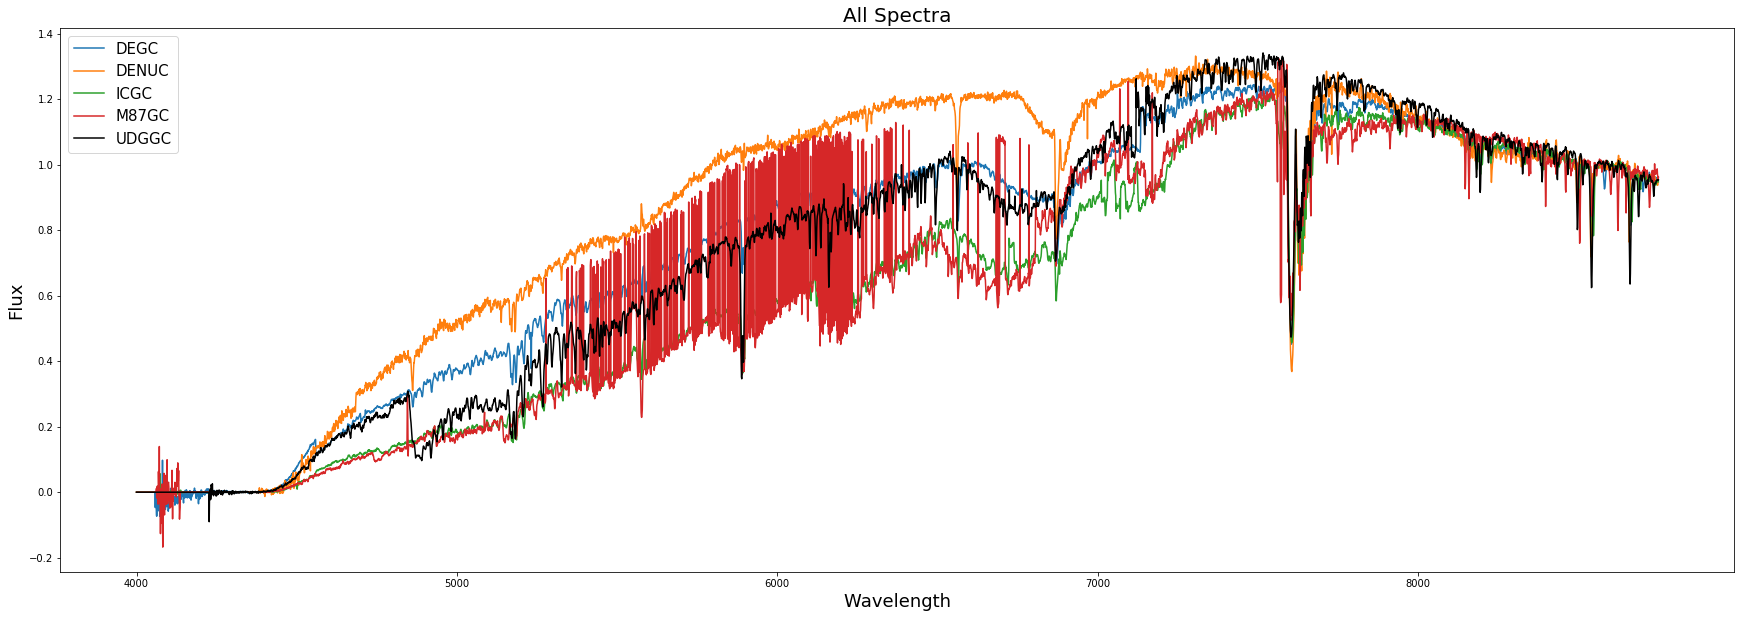

In [20]:
plot(coadd_spectraDEGC, coadd_spectraDENUC, coadd_spectraICGC, coadd_spectraM87GC, coadd_spectraUDGGC , 'All Spectra', coadd = True, xlim = False)

In [15]:
elapsed = timeit.default_timer() - start_time

In [16]:
elapsed

143.3547446

In [21]:
m87gc

['spec1d.vdgc6.004.alg207.fits',
 'spec1d.vdgc6.005.nuc5.fits',
 'spec1d.vdgc6.007.gcA8.fits',
 'spec1d.vdgc6.009.gcA10.fits',
 'spec1d.vdgc6.015.gcA23.fits',
 'spec1d.vdgc6.017.serendip1.fits',
 'spec1d.vdgc6.018.gcA31.fits',
 'spec1d.vdgc6.044.gcN220.fits',
 'spec1d.vdgc6.045.gcN221.fits',
 'spec1d.vdgc6.046.gcN223.fits',
 'spec1d.vdgc6.049.gcN240.fits',
 'spec1d.vdgc6.053.vir316.fits',
 'spec1d.vdgc6.054.sgr389.fits',
 'spec1d.vdgc6.057.sgr415.fits',
 'spec1d.vdgc6.058.sgr416.fits',
 'spec1d.vdgc6.060.sgr418.fits',
 'spec1d.vdgc7.023.gcN114.fits',
 'spec1d.vdgc7.052.mst518.fits',
 'spec1d.vdgc8.040.gcN168.fits',
 'spec1d.vdgc8.043.gcN197.fits',
 'spec1d.vdgc8.046.vir325.fits',
 'spec1d.vdgc8.047.vir332.fits',
 'spec1d.vdgc8.050.sgr395.fits',
 'spec1d.vdgc8.054.sgr429.fits',
 'spec1d.vugc6.021.GCXO0092.fits.gz']

In [29]:
for name in icgc:
    if('[]' not in (str(df[df['SPEC1DNAME'] == name]['Type']))):
        print(str(df[df['SPEC1DNAME'] == name]['Type']))
    else:
        print((str((df[df['SPEC1DNAME']== name[:-3]])['Type'])))

3    ICGC
Name: Type, dtype: object
4    ICGC
Name: Type, dtype: object
6    ICGC
Name: Type, dtype: object
12    ICGC
Name: Type, dtype: object
39    ICGC
Name: Type, dtype: object
46    ICGC
Name: Type, dtype: object
70    ICGC
Name: Type, dtype: object
92    ICGC
Name: Type, dtype: object
116    ICGC
Name: Type, dtype: object
126    ICGC
Name: Type, dtype: object
151    ICGC
Name: Type, dtype: object
185    ICGC
Name: Type, dtype: object
237    ICGC
Name: Type, dtype: object
245    ICGC
Name: Type, dtype: object
257    ICGC
Name: Type, dtype: object
258    ICGC
Name: Type, dtype: object
284    ICGC
Name: Type, dtype: object
292    ICGC
Name: Type, dtype: object
342    ICGC
Name: Type, dtype: object
344    ICGC
Name: Type, dtype: object
409    ICGC
Name: Type, dtype: object
414    ICGC
Name: Type, dtype: object
417    ICGC
Name: Type, dtype: object
419    ICGC
Name: Type, dtype: object
435    ICGC
Name: Type, dtype: object
436    ICGC
Name: Type, dtype: object
440    ICGC
Name: Type,

In [24]:
df[df['SPEC1DNAME'] =='spec1d.vugc6.021.GCXO0092.fits.gz']

,VCC,TARGTYPE,GCSAT,HOST,RA,DEC,VHEL,VERR,VERR_pe,VERR_ne,...,MASKNAME,SLITNUM,ZSPECNUM,ZQUAL,YLOW,YHIGH,SPEC1DNAME,Type,Probability,Nucleus
